<a href="https://colab.research.google.com/github/bengtlofgren/ML_Dump/blob/main/17022088_part_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL coursework, part I (20 pts total)
---

**SN:** Your Student Number

---

**Due date:** *22nd March, 2022,*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [ ]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [ ]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [ ]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [ ]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [ ]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [ ]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):

    if previous_action is None:
        return np.random.randint(0, self._number_of_arms)
    self.t += 1
    #We took another action here, so count it
    self.actions_taken[previous_action] += 1
    #Update action value
    self.Q_a[previous_action] += 1/self.actions_taken[previous_action] * (reward - self.Q_a[previous_action])
    
    action = np.argmax(self.Q_a + self._bonus_multiplier * np.sqrt(np.log(self.t)/(2*self.actions_taken))) 
    
    assert action < self._number_of_arms, "UCB"
    return action

  def reset(self):
    self.Q_a = np.zeros(self._number_of_arms)
    self.actions_taken = np.zeros(self._number_of_arms) + 1e-16
    self.t = 0

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [ ]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    

    if previous_action is None:
        return np.random.randint(0, self._number_of_arms)
    
    self.t += 1
    
    #We took another action here, so count it
    self.actions_taken[previous_action] += 1
    #Update action value
    self.Q_a[previous_action] += 1/self.actions_taken[previous_action] * (reward - self.Q_a[previous_action])
    
    if callable(self._epsilon):
        epsilon = self._epsilon(self.t)
    else:
        epsilon = self._epsilon

    if np.random.uniform(0,1) <= epsilon:
        action = np.random.randint(0, self._number_of_arms)
    else:
        action = np.random.choice(np.arange(0, self._number_of_arms)[self.Q_a == np.max(self.Q_a)])
    
    assert action < self._number_of_arms, "EPGREED" 
    return action

  def reset(self):
    self.Q_a = np.zeros(self._number_of_arms)
    self.actions_taken = np.zeros(self._number_of_arms)
    self.t = 0

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [ ]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self._number_of_arms = number_of_arms
    self._step_size = step_size
    self._baseline = baseline

  def step(self, previous_action, reward):
    
    
    if previous_action is None:
        return np.random.randint(0, self._number_of_arms)
    self.t+=1
    

    #Update cumreward
    if self._baseline:
        self._adjustment += self._step_size * (reward - self._adjustment)
    
    #Update using gradient (all preferences are updated in some way, but previous action preference additionally updated)
    self.action_pref += self._step_size * (reward - self._adjustment) * (0 -
                                       2*self.policy / self.action_pref) 
    self.action_pref[previous_action] += self._step_size * (reward - self._adjustment) * (2/self.action_pref[previous_action])
    
    #Update policy
    self.update_policy()
    
    #Choosing action: this is just an efficient way of sampling according to our distribution
    #np.sum will sum all the booleans and we want the first index where this boolean is True
    temp = np.cumsum(self.policy) < np.random.uniform(0,1)
    action = np.sum(temp)
    return action

  def reset(self):
    #Initalise some random action preferences
    self.action_pref = np.ones(self._number_of_arms)
    # # Normalise
    # self.action_pref/= np.sum(self.action_pref)
    self.update_policy()
    self._adjustment = 0
    self.t = 0

  def update_policy(self):
    self.policy = (self.action_pref ** 2) / (np.sum(self.action_pref ** 2))

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [ ]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

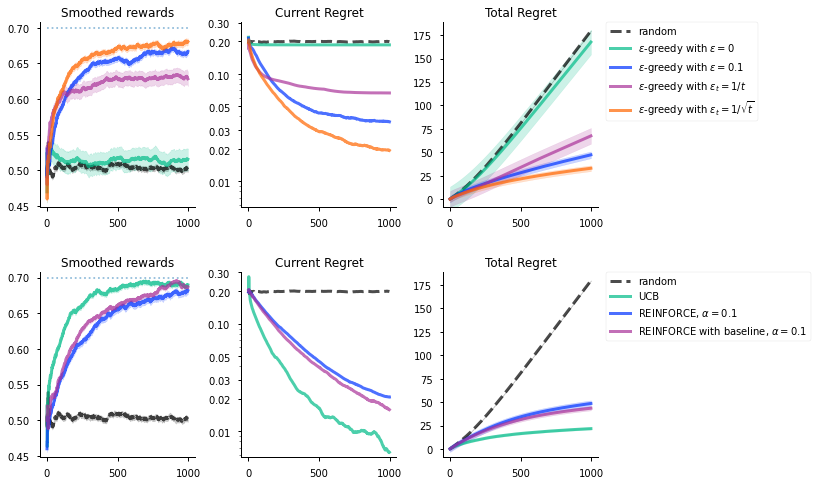

In [ ]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

1.   **$\epsilon$-greedy, $\epsilon = 0$**
This algorithm performs no exploration, given its initialisation is not overly optimistic. If it is able to recover the value estimate quickly, it will experience 0 regret, otherwise it will experience linear total regret.

2.   **$\epsilon$-greedy, $\epsilon = 0.1$**
This algorithm constantly explores 10% of the time, and therefore should be expected to experience linear total regret, since it will always be exploring (10% of the time hence make the wrong decision at a rate 0.1 * $\frac{\text{number of arms} - 1}{\text{number of arms}}$), yet due to its exploring, it will eventually converge to choosing the optimal action at a rate ($0.9 + \frac{1}{\text{number of arms}}$).

3. **$\epsilon$-greedy, $\epsilon = \frac{1}{t}$**
Its expected performance will depend on the number of arms for the bandit. This algorithm will converge in the plim to the epsilon greedy policy as $t → ∞$, and the average reward will be a consistent estimator of the average reward of the optimal policy (as the variance of the average reward is 0 in the plim). However, whether it performs well in the short term will depend on the number of arms, as with fewer number of arms, it will be expected to sufficiently explore in order to outperform $\epsilon$-greedy, $\epsilon = 0.1$, (if the algorithm is able to explore sufficiently in the first 10 time steps), however this does not seem to be the case here. In the long run, it is expected to approach 0 (current) regret. Total regret will be expected to grow sublinearly.

4.  **$\epsilon$-greedy, $\epsilon = \frac{1}{\sqrt{t}}$**
Its expected performance will also depend on the number of arms for the bandit. Although it will be able to converge to the optimal action policy, the variance of the average reward in the long term will be infinite, and therefore does not asymptotically converge in terms of total regret = 0. In the short term, it is able to perform well, as it explores more and is able to gain a better estimate for the value function, and therefore performs well. Total regret will be expected to grow sublinearly.

5. **UCB**
This algorithm will be able to find experience the lowest total regret, as its total regret grows logarithmically. It chooses the best action based on its current based estimate plus a penalty term for underexploration. 

6. **REINFORCE (w/out Baseline) **
This algorithm attempts to approximate the value function through stochastic gradient descent. If the value function can be approximated, its total regret is expected to grow sublinearly until it reaches (close to) 0 as the value estimate grows.

7. **REINFORCE (w/ Baseline) **
The algorithm's total regret will grow (in expectation) similar to REINFORCE without baseline. However the variance of the regret will decrease due to the baseline.



**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

As can be seen from the plots, the $\epsilon$-greedy algorithm with dynamic epsilon of $\epsilon_t = \frac{1}{\sqrt{t}}$ performed the best. This was (closely) followed by $\epsilon_t = 0.1$. Intuitively, these algorithms performed well, because they explored more than the other algorithms. With $\epsilon_t = \frac{1}{\sqrt{t}}$, the algorithm explores the most than any algorithm $ \forall t < 100 $, after which it explores less. It can be shown that each arm is explored an infinite amount of times, however, whether it performs better than $\epsilon_t = 0.1$ depends on the number of arms and whether the problem is stationary. If it is highly non-stationary, we could expecte $\epsilon_t = 0.1$ to perform the best. In this case, the problem was stationary and there were few enough arms for $\epsilon_t = \frac{1}{\sqrt{t}}$ to be strictly preferred.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [ ]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

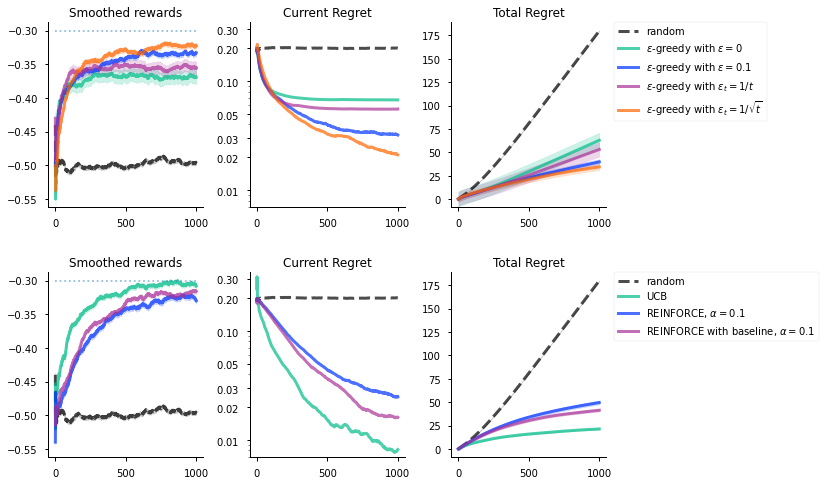

In [ ]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

1.   **$\epsilon$-greedy, $\epsilon = 0$**
Significant change, due to its sensitivity to initialisation. If the initial estimates of the action values are overly optimistic, it will tend explore each optimistic action at least once, giving it more accurate returns to estimate on.

2.   **$\epsilon$-greedy, $\epsilon = 0.1$**
Change, but not as signficant as $\epsilon = 0$. This is simply because it will explore regardless, but helps it explore in the beginning.

3. **$\epsilon$-greedy, $\epsilon = \frac{1}{t}$**
Significant change, due to similar argument as 1.

4.  **$\epsilon$-greedy, $\epsilon = \frac{1}{\sqrt{t}}$**
Significant change , due to similar argument as 1.

5. **UCB**
No significant change, not as sensitive to initialisation. Although it uses the same update function as $\epsilon$-greedy, it will explore more regardless.

6. **REINFORCE (w/out and w/out Baseline)**
No change, not very sensitive to initialisation due to updating all states at once.

## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [ ]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [ ]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

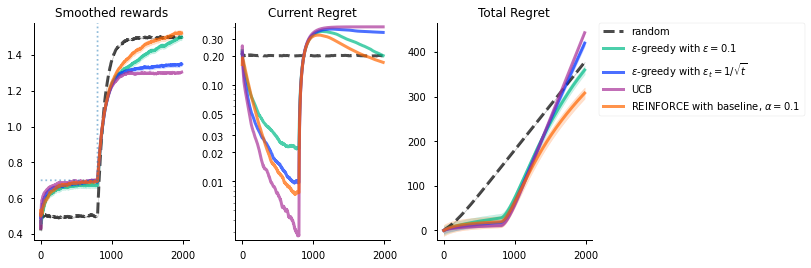

In [ ]:
experiment3.show()

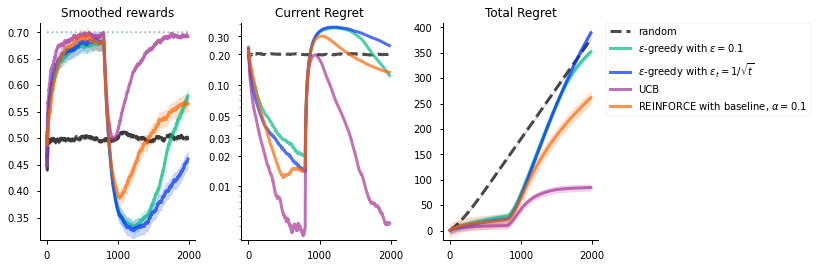

In [ ]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> Here, UCB performs the worst, followed by $\epsilon$-greedy $ \epsilon_t = \frac{1}{\sqrt{t}}$, REINFORCE (w/ baseline), and finally $\epsilon$-greedy $\epsilon = 0.1$, which performs the best. This is due partly to the fact that the reward changes so late (meaning that uncertainty in all other algorithms for less-used arms is low), but mostly due to the underlying reward for the previously best action not having decreased. This means that the UCB and REINFORCE algorithms do not update their action policies significantly until when they choose a low probability action (which after ~1000 steps is increasingly unlikely). Due to the late change in reward, the $\epsilon$-greedy $ \epsilon_t = \frac{1}{\sqrt{t}}$ is unable to compete as its effective epsilon is only ~ $\frac{1}{10\sqrt{10}}$.

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> Becuase of the change to the underlying reward of the previous best action being decreased, now the UCB and REINFORCE algorithms are able to capitalise and show better performance. The new rankings are, from best to worst:
UCB, followed by REINFORCE (w/ baseline), $\epsilon$-greedy $\epsilon = 0.1$, and finally $\epsilon$-greedy $ \epsilon_t = \frac{1}{\sqrt{t}}$, which performs the worst. Both REINFORCE and UCB update their policy estimates by the reward it receives, compared to what was expected, for choosing the particular action. Because the reward of the favoured action drops to that of the unfavoured action, the policy is able to quickly update and start exploring again, and as can be seen, the UCB algorithm is able to take advantage of this more effectively. 

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> This was alluded to in the above answer, but to go into more detail:
The UCB update is given by 
$Q_t(A_t) = Q_{t-1}(A_t) + \frac{1}{N_t(a)} (R_{t} - Q_{t-1}(A_{t-1}))$, and hence if the action value for the preferred action has converged close to $R_{t}$ the update in experiment 3 will be negligible when choosing that action (as the reward has not changed). When the action for the unpreferred action is chosen, the update will be significant. However, the algorithm only chooses the unpreferred action when 
$Q_{t-1}(b) + \frac{\ln{t}}{N_t(b)} > Q_{t-1}(a) + \frac{\ln{t}}{N_t(a)}$ where b and a are the unpreferred and preferred actions, respectively.


**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> This can be done by adjusting the UCB algorithm in order to weight more recent rewards more highly. Hence, the UCB algorithm will sacrifice its properties of convergence to the true action value (as the variance of its estimate is now infinite) in favor of being more robust to non-stationarity. A naive approach that would achieve this is to make the step-size parameter $\alpha$ be independent of time, however may increase variance excessively. Some novel alternative methods have been studied, including the discounted and sliding-window UCB methods. The discounted UCB (D-UCB) includes a discount for the rewards in order to weight more recent rewards greater. The D-UCB algorithm reformulates the average rewards as 
\begin{equation}\overline{R}_t(\gamma, a) = \frac{1}{N_t(\gamma, i)} \sum_{s=1}^t \gamma^{t-s}R_s(a)\mathbb{1}_{\{A_s = a\}} \end{equation} and \begin{equation}N_t(\gamma, a ) = \sum_{s=1}^t \gamma^{t-s} \mathbb{1}_{\{A_s = a\}} \end{equation}
Now instead, the algorithm chooses the optimal action based on
\begin{equation} \arg\max_a \overline{R}_t(\gamma, a) + c * \sqrt{\frac{\log \sum_{a \in A} N_t(\gamma, a)}{N_t(\gamma, a)}}
\end{equation} Where c is some tunable hyperparameter. The Sliding Window UCB SW-UCB is defined similarly, except replacing the discount factor with some truncation time $\tau$ such that steps $t-s > \tau$ in the past are forgotten. These have been shown to perform well under highly non-stationary environments. <div class="csl-entry">Garivier, A. (2008). <i>On Upper-Confidence Bound Policies for Non-Stationary Bandit Problems Eric Moulines</i>.</div>
